## Try to replicate SMT

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *


# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is enabled!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is enabled!")



MPS is enabled!
MPS is enabled!


### 1. Generate data from Archimedean spiral

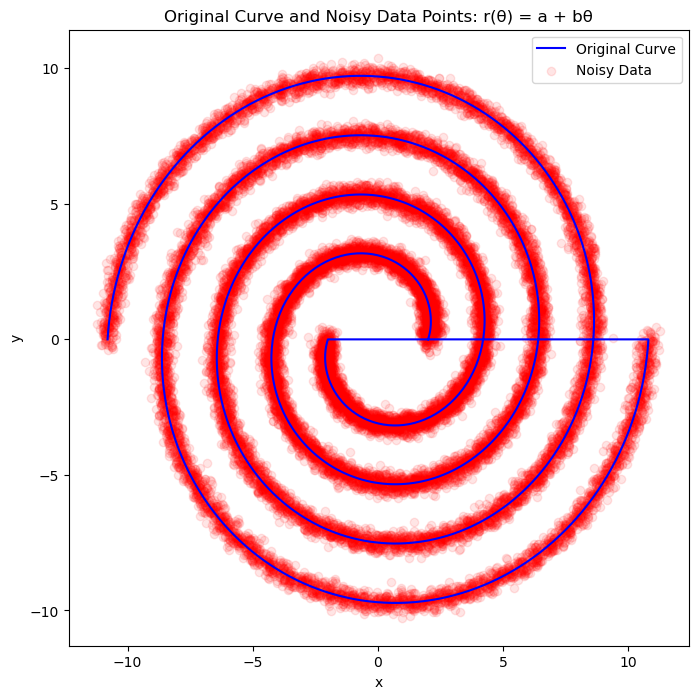

In [2]:
data = GenerateDataset()

## 2. Sparse coding

In [3]:
data_tensor = torch.tensor(data, dtype=torch.float,device = device)

# Create an instance of SparseCoding model
model = SparseCoding(data_size=data_tensor.shape[0], activ_dim=data_tensor.shape[1], basisfunc_num=700, sparsity_level=0)


# Define optimizer for Biasis update
optimizer = optim.Adam([model.Activ, model.Basis], lr=0.01)

# Number of optimization steps
num_epochs = 3000

# Training loop
for epoch in range(num_epochs):

    # Update A
    dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
    min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each row
    model.Activ.zero_()
    model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

    # Update B
    cost = model.loss(data_tensor)
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Cost = {cost}')

    if cost <= 1e-2:
        print('training ended!')
        break

# After training, you can use the learned dictionary to encode new data
encoded_data = model.Activ @ model.Basis
print("Encoded data shape:", encoded_data.shape)



Epoch [10/3000], Cost = 0.21780578792095184
Epoch [20/3000], Cost = 0.1713029444217682
Epoch [30/3000], Cost = 0.13908320665359497
Epoch [40/3000], Cost = 0.11553356796503067
Epoch [50/3000], Cost = 0.09753501415252686
Epoch [60/3000], Cost = 0.08406664431095123
Epoch [70/3000], Cost = 0.07439815253019333
Epoch [80/3000], Cost = 0.06748677790164948
Epoch [90/3000], Cost = 0.0628625899553299
Epoch [100/3000], Cost = 0.05960526689887047
Epoch [110/3000], Cost = 0.05724106729030609
Epoch [120/3000], Cost = 0.05553727224469185
Epoch [130/3000], Cost = 0.0541963204741478
Epoch [140/3000], Cost = 0.05302194133400917
Epoch [150/3000], Cost = 0.052058249711990356
Epoch [160/3000], Cost = 0.05121898278594017
Epoch [170/3000], Cost = 0.05044449493288994
Epoch [180/3000], Cost = 0.04981231689453125
Epoch [190/3000], Cost = 0.04928603023290634
Epoch [200/3000], Cost = 0.04882413148880005
Epoch [210/3000], Cost = 0.04846741631627083
Epoch [220/3000], Cost = 0.04815591499209404
Epoch [230/3000], Cos

### Plot learnt dictionary and clustered data points

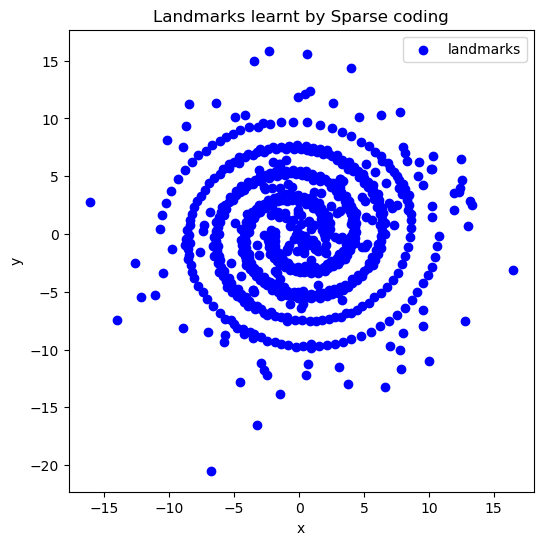

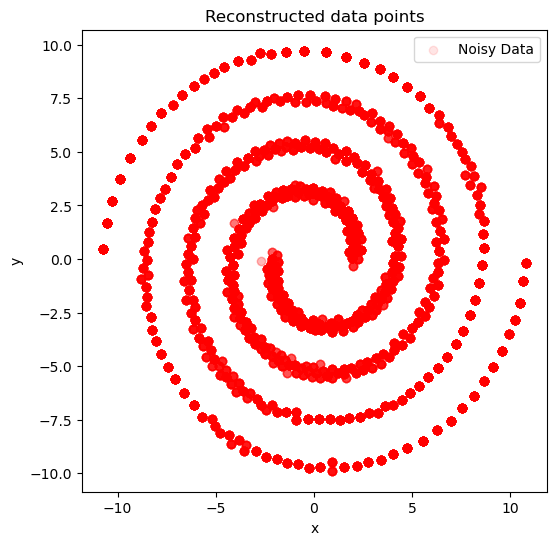

1.0


In [4]:

# return sum_squared_error/num_samples
Bas = model.Basis.detach().cpu()
Act = model.Activ.detach().cpu()

recon = Act @ Bas
# Plotting in polar coordinates

# Original curve label='Original Curve', color='blue')
model.plot_basis()

plt.figure(figsize=[6, 6])

# Noisy data points
ax = plt.subplot(111)
ax.scatter(recon[:, 0], recon[:, 1], label='Noisy Data', color='red', alpha=0.1)

# Setting the title and labels
ax.set_title("Reconstructed data points")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Show the plot

print(np.linalg.norm(Act[0,:]))


## 2. Assign similarity (Define D)

### 2.1 K-nearest neighbours in dictionary (B)

In [5]:
## Compute K-nearest neighbors for each element in model.Basis

# Compute K-nearest neighbors
neighbors_indices = model.KNN(5).detach().cpu()
print("K-nearest neighbors indices:")
print(neighbors_indices)

K-nearest neighbors indices:
tensor([[332, 676, 405, 197, 353],
        [520, 536, 380, 542, 294],
        [328, 376, 277, 319,  77],
        ...,
        [538, 413, 147, 643, 208],
        [193, 538, 643, 182, 310],
        [217, 329, 320, 495, 482]])


torch.Size([5, 2])
torch.Size([5, 2])


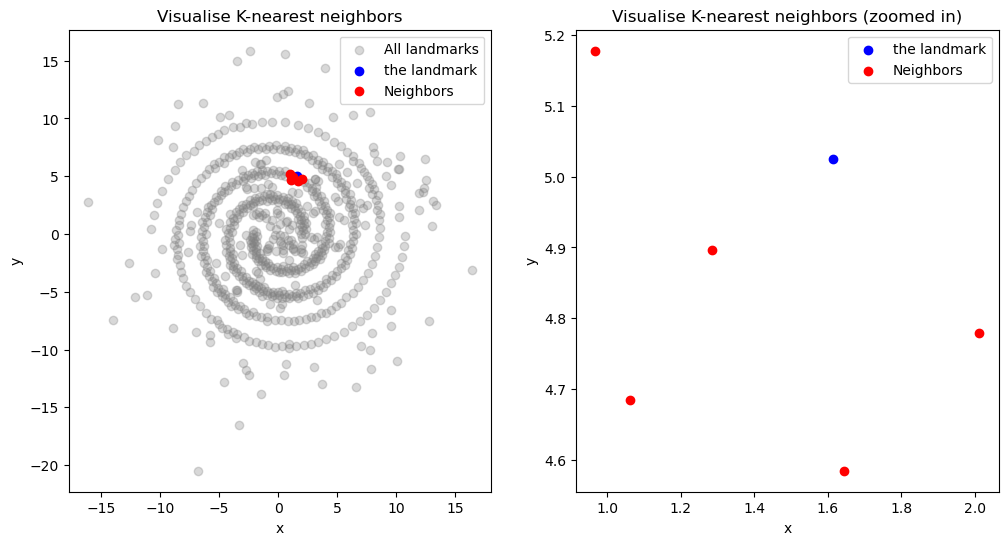

In [6]:
## plot neighbors for a landmark
idx = 400

fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

# plot dictionary elements
ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', color='gray', alpha=0.3)

ax.scatter(Bas[idx,0], Bas[idx,1], label='the landmark', color='blue', alpha=1)
neighbors = Bas[neighbors_indices[idx],:]
print(neighbors.shape)
ax.scatter(neighbors[:,0], neighbors[:,1], label='Neighbors', color='red', alpha=1)

# Setting the title and labels
ax.set_title("Visualise K-nearest neighbors")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

ax1.scatter(Bas[idx,0], Bas[idx,1], label='the landmark', color='blue', alpha=1)
neighbors = Bas[neighbors_indices[idx],:]
print(neighbors.shape)
ax1.scatter(neighbors[:,0], neighbors[:,1], label='Neighbors', color='red', alpha=1)

# Setting the title and labels
ax1.set_title("Visualise K-nearest neighbors (zoomed in)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()
plt.show()


### 2.2 Construct D from B
Goal: minimising distance between neighbours


### !!Skipped due to dimension issue!!

In [7]:
# a = torch.zeros(7,4,7)
# b = torch.zeros(7,5)

# print((a@b@b.T@a.T).shape)
# # print(a.shape)
# # print(((a@a).shape))

Goal: keep topology by using interpolation (LLE on dictionary elements)

In [8]:
## Weight matrix
neighbors_indices = model.KNN(5)

Basis = model.Basis.detach()

neighbors = Basis[neighbors_indices,:] # (700,k,2)

print('neighbors shape: ', neighbors.shape)

local_cov = (Basis.unsqueeze(1)-neighbors) @ torch.transpose((Basis.unsqueeze(1)-neighbors), dim0=1, dim1=2) # (700,k,k)=(700,k,2)@(700,2,k)
local_cov_inv = torch.inverse(local_cov) # (700,k,k)

print(local_cov[1]@local_cov_inv[1])
weight = torch.sum(local_cov_inv,dim=1) / torch.sum(local_cov_inv,dim=[1,2]).unsqueeze(1) #(700,k)

print('weight: ', weight.unsqueeze(-1).shape)
recon_landmark = torch.transpose(neighbors,dim0=1,dim1=2) @ weight.unsqueeze(-1) # (700,2,k) @ (700,k,1)
recon_landmark.squeeze_(2)
print(recon_landmark.shape)
print('interpolation error: ')
print(recon_landmark - Basis)

# check sum of weight
print(torch.sum(weight,dim=1))


neighbors shape:  torch.Size([700, 5, 2])
tensor([[ 1.4134, -1.6161, -0.1359, -0.2155,  0.0089],
        [-2.4493,  3.4733,  0.4213, -0.7498, -0.0464],
        [ 3.8196, -3.9143,  0.4954, -0.5024, -0.2279],
        [ 0.2917,  4.8814,  0.2966, -1.8080,  0.0480],
        [-0.0949, -0.0513, -0.0440,  0.1032,  0.9961]], device='mps:0')
weight:  torch.Size([700, 5, 1])
torch.Size([700, 2])
interpolation error: 
tensor([[-2.3842e-07,  0.0000e+00],
        [-9.5367e-07, -1.9073e-06],
        [-1.1921e-07,  5.9605e-08],
        ...,
        [ 5.9605e-08,  0.0000e+00],
        [ 2.3842e-07,  1.0490e-05],
        [ 1.4305e-06,  1.4305e-06]], device='mps:0')
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 

torch.Size([700, 5])
torch.Size([700, 5])
tensor([-1.4305e-06, -1.7881e-07])


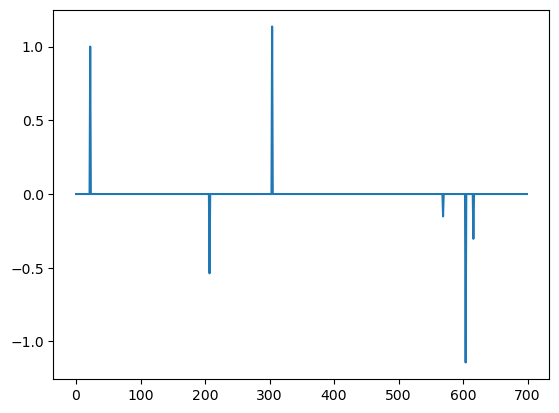

In [10]:
print(neighbors_indices.shape)
print(weight.shape)
Diff = torch.eye(Basis.shape[0],Basis.shape[0], device=device)

# Iterate over each row (each landmark)
for i in range(neighbors_indices.size(0)):
    # Select vaelements from Diff based on indices and apply weights
    Diff[i, neighbors_indices[i]] -= weight[i]


# Validation 
diff = Diff.cpu()[22]
plt.plot(diff)
print(Bas.T @ diff)